In [ ]:
# Olivetti Research Laboratory (ORL) Dataset AT&T (American Telephone & Telegraph Company).

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kasikrit/att-database-of-faces")

print("Path to dataset files:", path)

100%|██████████| 3.61M/3.61M [00:00<00:00, 128MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2


In [11]:
import os
import cv2
import numpy as np

# Path to dataset
data_path = "/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2"

X = []   # images
y = []   # labels

for person_folder in os.listdir(data_path):
    person_path = os.path.join(data_path, person_folder)
    if os.path.isdir(person_path):
        label = int(person_folder[1:])  # folder 's1' -> label 1
        for img_name in os.listdir(person_path):
            img_path = os.path.join(person_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # already grayscale
            img = cv2.resize(img, (64, 64))  # resize to uniform size
            X.append(img)
            y.append(label)

X = np.array(X)
y = np.array(y)

print("Dataset shape:", X.shape, "Labels:", y.shape)


Dataset shape: (400, 64, 64) Labels: (400,)


In [12]:
X = X.astype("float32") / 255.0
X_flat = X.reshape(X.shape[0], -1)  # flatten: (400, 4096)
print("Flattened feature shape:", X_flat.shape)


Flattened feature shape: (400, 4096)


In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.3, stratify=y, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (280, 4096) Test: (120, 4096)


In [29]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# SVM with scaling
svm_clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=10, gamma=0.01))

svm_clf.fit(X_train, y_train)

print("Train accuracy:", svm_clf.score(X_train, y_train))
print("Test accuracy:", svm_clf.score(X_test, y_test))


Train accuracy: 1.0
Test accuracy: 0.3333333333333333


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           1       0.04      1.00      0.07         3
           2       1.00      0.33      0.50         3
           3       1.00      0.33      0.50         3
           4       1.00      0.33      0.50         3
           5       0.00      0.00      0.00         3
           6       1.00      1.00      1.00         3
           7       0.00      0.00      0.00         3
           8       1.00      0.33      0.50         3
           9       1.00      0.67      0.80         3
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         3
          12       1.00      0.33      0.50         3
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          15       1.00      1.00      1.00         3
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         3
          18       1.00    

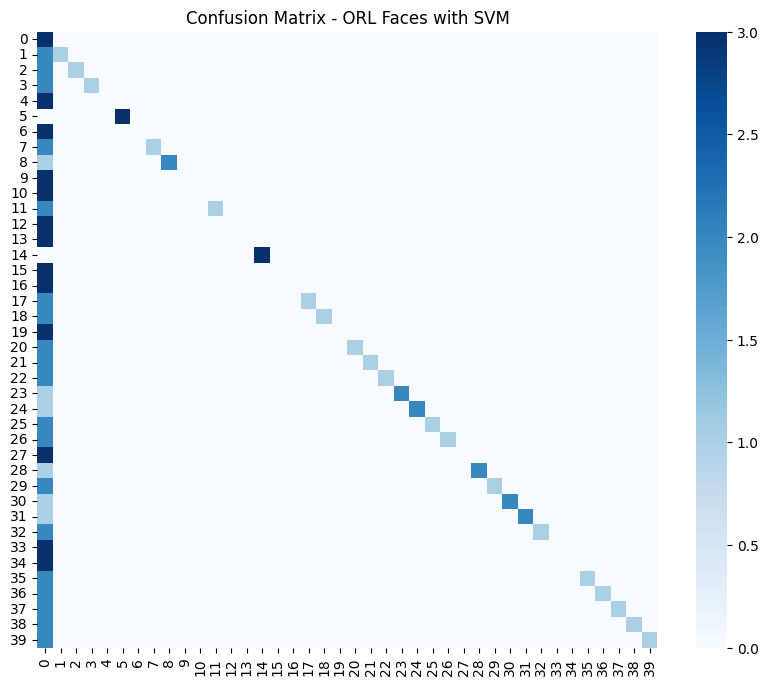

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = svm_clf.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix - ORL Faces with SVM")
plt.show()


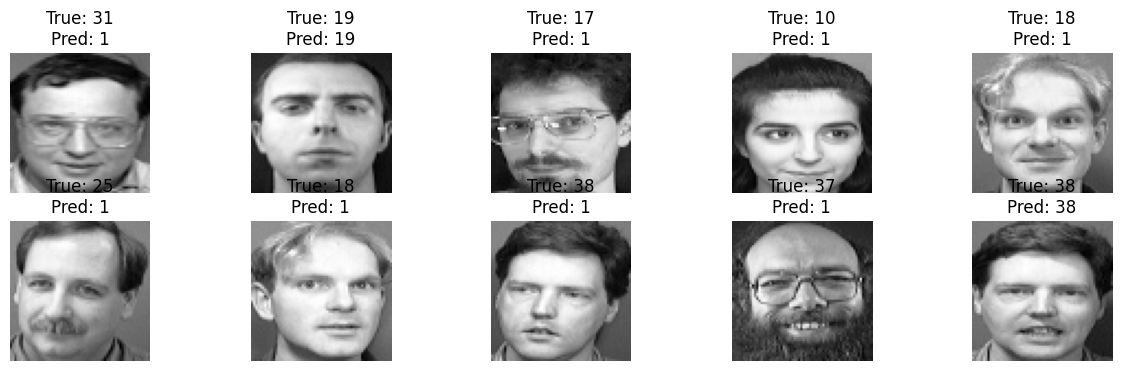

In [17]:
import matplotlib.pyplot as plt

# Pick first 10 test samples
n_samples = 10
plt.figure(figsize=(15, 4))

for i in range(n_samples):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(64, 64), cmap="gray")
    plt.title(f"True: {y_test[i]}\nPred: {y_pred[i]}")
    plt.axis("off")

plt.show()


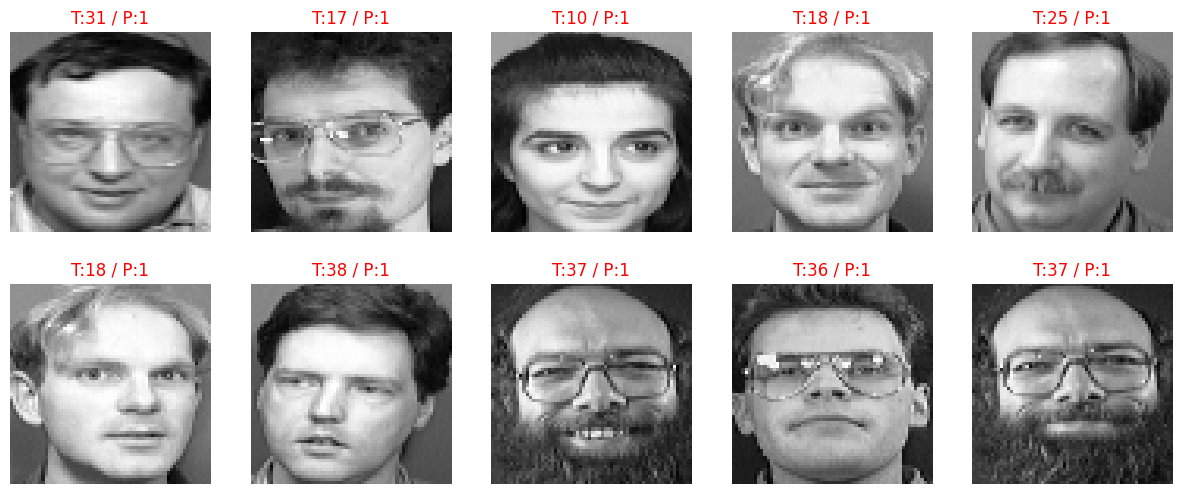

In [18]:
mis_idx = np.where(y_test != y_pred)[0]

plt.figure(figsize=(15, 6))
for i, idx in enumerate(mis_idx[:10]):  # show up to 10 misclassified faces
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx].reshape(64, 64), cmap="gray")
    plt.title(f"T:{y_test[idx]} / P:{y_pred[idx]}", color="red")
    plt.axis("off")

plt.show()


In [ ]:
#------------------FEATURE EXTRACTION ----------------------

In [19]:
# Raw Pixel Intensities
#Each pixel’s brightness value (0 = black, 255 = white).
#A 64×64 image → 4096 features (one for each pixel).
#Signifies absolute light/dark pattern at every location.
#Problem: if the person moves slightly, the pixel values shift drastically.

print("Feature vector shape:", X_train[0].shape)  # should show (4096,)


Feature vector shape: (4096,)


HOG feature length: 1764


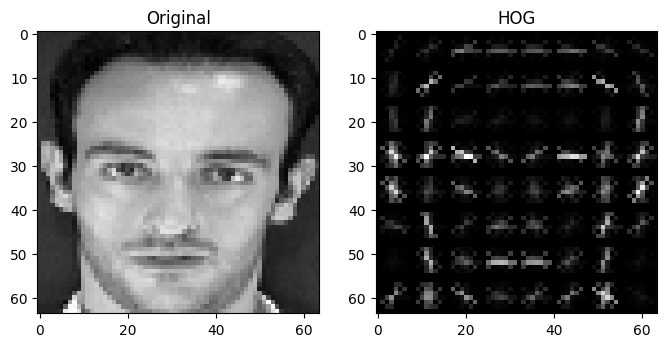

In [20]:
#HOG (Histogram of Oriented Gradients)
#Captures the direction of edges in small parts of the image.
#Example:
#A vertical line (like the nose bridge) gives strong vertical gradients.
#Curves (eye outline, lips) give circular/angled gradients.
#Signifies shapes and structures → makes it easier to distinguish “where the eyes, mouth, and nose edges are.”

from skimage.feature import hog

# Example on first image
features, hog_image = hog(X_train[0].reshape(64, 64),
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          visualize=True)

print("HOG feature length:", len(features))

# Show original + HOG visualization
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(X_train[0].reshape(64, 64), cmap="gray")
ax1.set_title("Original")
ax2.imshow(hog_image, cmap="gray")
ax2.set_title("HOG")
plt.show()


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


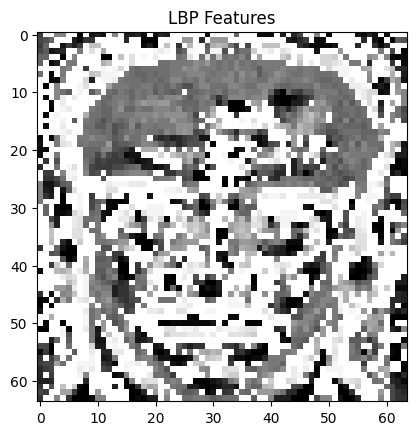

In [21]:
#LBP (Local Binary Pattern)
#Looks at a pixel’s neighborhood and compares brightness.
#Example:
#Smooth skin = uniform pattern.
#Wrinkles, beard, hair = irregular patterns.
#Signifies textures → helps differentiate, e.g., a bearded vs. clean-shaven face.

from skimage.feature import local_binary_pattern

radius = 3
n_points = 8 * radius
lbp = local_binary_pattern(X_train[0].reshape(64, 64), n_points, radius, method='uniform')

plt.imshow(lbp, cmap="gray")
plt.title("LBP Features")
plt.show()


In [22]:
#PCA (Principal Components / Eigenfaces)
#Finds the most important variations across all faces.
#Example:
#One principal component may capture face width.
#Another may capture eye-to-mouth distance.
#Another may capture skin tone/lightness.
#Signifies abstract “face patterns” → not directly visible, but combinations reconstruct faces.

from sklearn.decomposition import PCA

pca = PCA(n_components=50)  # keep top 50 features
X_pca = pca.fit_transform(X_train)

print("Original feature size:", X_train.shape[1])
print("Reduced feature size:", X_pca.shape[1])


Original feature size: 4096
Reduced feature size: 50


In [23]:
import os

data_path = "/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2"

for root, dirs, files in os.walk(data_path):
    print(root, len(files), "files")


/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2 1 files
/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2/s15 10 files
/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2/s4 10 files
/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2/s23 10 files
/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2/s29 10 files
/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2/s37 10 files
/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2/s36 10 files
/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2/s26 10 files
/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2/s39 10 files
/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2/s18 10 files
/root/.cache/kagglehub/datasets/kasikrit/att-database-of-faces/versions/2/s33 10 files
/root/.cache/kagglehub/datasets/kasikrit/att-data

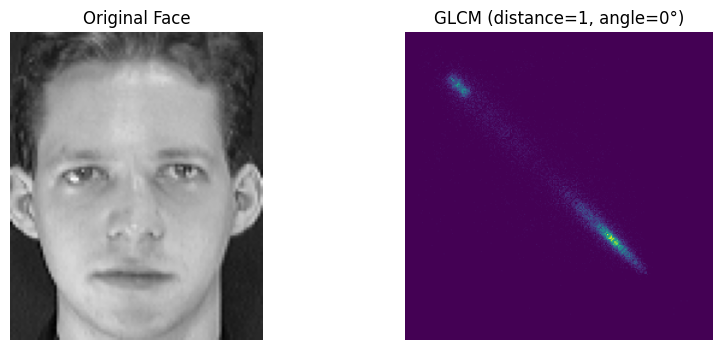

GLCM matrix shape: (256, 256, 1, 4)

GLCM Texture Features for this image:

contrast       : [215.3774529  257.8955549  128.70094007 298.29066429]
dissimilarity  : [7.79130691 9.10969211 6.42969056 9.34917335]
homogeneity    : [0.18461543 0.16615497 0.2156251  0.17023967]
energy         : [0.02388418 0.02288777 0.02570529 0.02271055]
correlation    : [0.96167472 0.95393546 0.97727944 0.94671856]
ASM            : [0.00057045 0.00052385 0.00066076 0.00051577]


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from skimage import io
import os

# Pick one sample image (say s1/1.pgm)
img_path = os.path.join(data_path, "s1", "1.pgm")
image = io.imread(img_path)

# Compute GLCM for distance=1, angles=0,45,90,135
glcm = graycomatrix(image,
                    distances=[1],
                    angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                    symmetric=True,
                    normed=True)

# Extract features
props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
features = {p: graycoprops(glcm, p)[0] for p in props}

# ------------------------------
# Visualization
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Original face image
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Face")
axes[0].axis("off")

# Show GLCM heatmap for 0° (first angle)
axes[1].imshow(glcm[:, :, 0, 0], cmap='viridis')
axes[1].set_title("GLCM (distance=1, angle=0°)")
axes[1].axis("off")

plt.show()

# Print size of GLCM
print("GLCM matrix shape:", glcm.shape)

# Print texture features
print("\nGLCM Texture Features for this image:\n")
for k, v in features.items():
    print(f"{k:15s}: {v}")


Train accuracy: 1.0
Test accuracy: 0.975

Classification Report (Random Forest):

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       0.75      1.00      0.86         3
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       0.75      1.00      0.86         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00      1.00      1.00         3

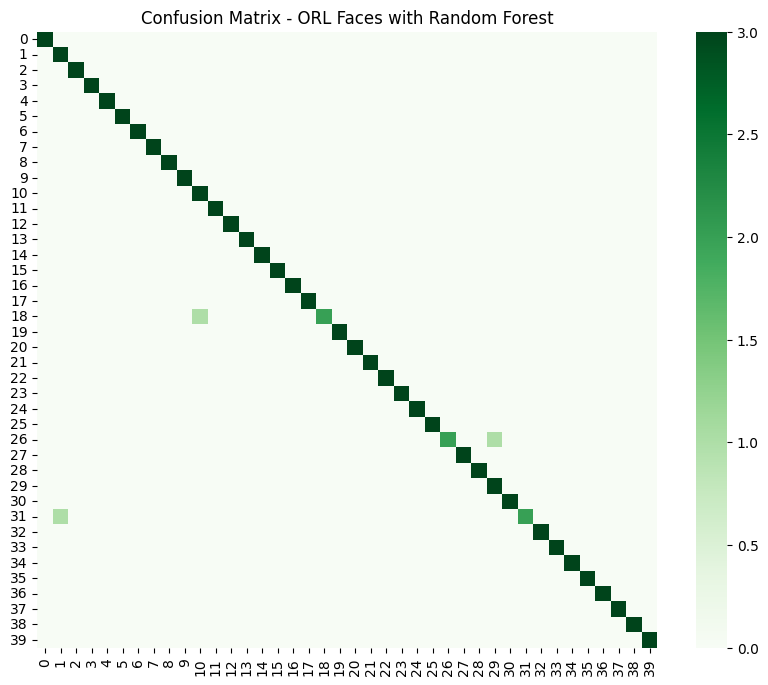

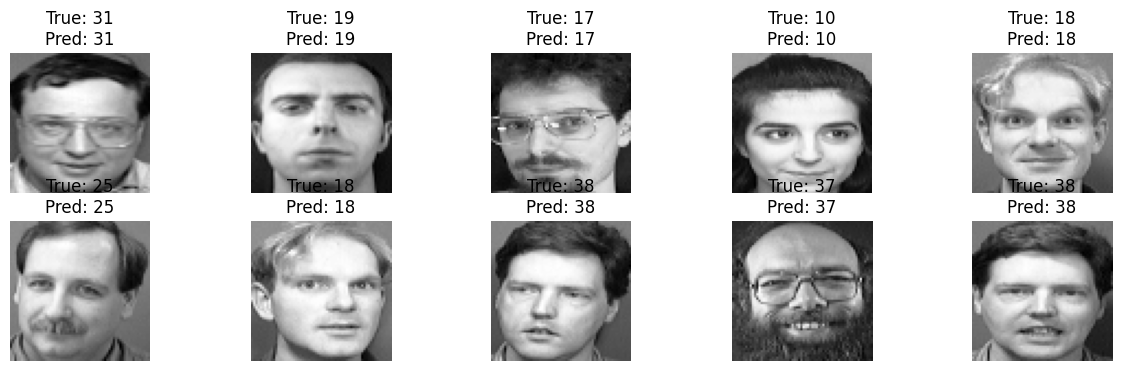

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Random Forest with some hyperparameters
rf_clf = RandomForestClassifier(
    n_estimators=300,    # number of trees
    max_depth=40,        # max depth of each tree
    random_state=42
)

# Train
rf_clf.fit(X_train, y_train)

# Evaluate
print("Train accuracy:", rf_clf.score(X_train, y_train))
print("Test accuracy:", rf_clf.score(X_test, y_test))

# Predictions
y_pred_rf = rf_clf.predict(X_test)

# Classification report
print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Greens")
plt.title("Confusion Matrix - ORL Faces with Random Forest")
plt.show()

# Visualize first 10 test samples with predictions
n_samples = 10
plt.figure(figsize=(15, 4))

for i in range(n_samples):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(64, 64), cmap="gray")
    plt.title(f"True: {y_test[i]}\nPred: {y_pred_rf[i]}")
    plt.axis("off")

plt.show()


HOG feature shape: (400, 1764)
Train accuracy: 1.0
Test accuracy: 0.9666666666666667

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3
           3       0.75      1.00      0.86         3
           4       0.67      0.67      0.67         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00         3
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         3
          16       1.00  

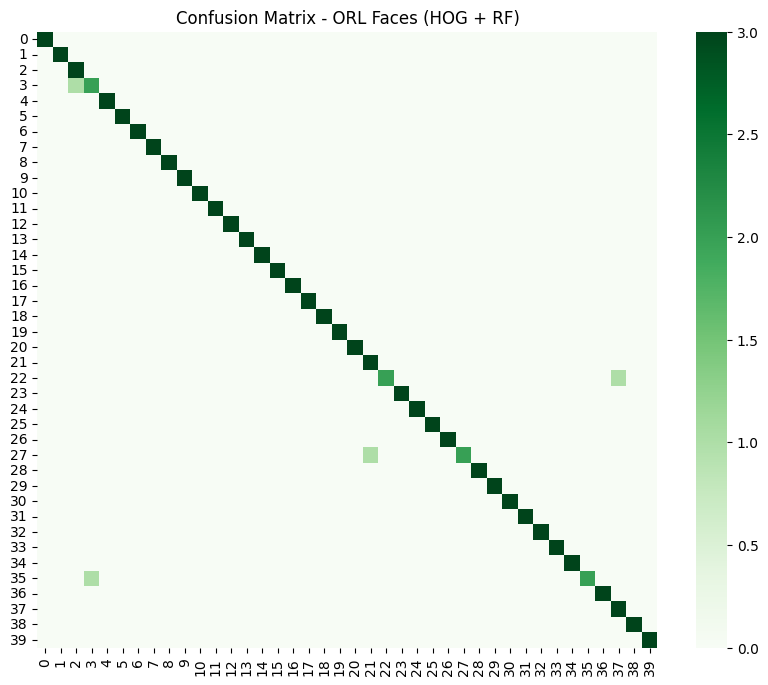

In [30]:
from skimage.feature import hog
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Extract HOG features for all images
hog_features = []
for img in X:  # X is still shape (400, 64, 64)
    feat = hog(img, orientations=9, pixels_per_cell=(8, 8),
               cells_per_block=(2, 2), visualize=False)
    hog_features.append(feat)

hog_features = np.array(hog_features)
print("HOG feature shape:", hog_features.shape)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    hog_features, y, test_size=0.3, stratify=y, random_state=42
)

# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=40,
    random_state=42
)
rf_clf.fit(X_train, y_train)

print("Train accuracy:", rf_clf.score(X_train, y_train))
print("Test accuracy:", rf_clf.score(X_test, y_test))

# Predictions
y_pred_rf = rf_clf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Greens")
plt.title("Confusion Matrix - ORL Faces (HOG + RF)")
plt.show()


In [31]:
from skimage.feature import local_binary_pattern

radius = 3
n_points = 8 * radius

lbp_features = []
for img in X:
    lbp = local_binary_pattern(img, n_points, radius, method='uniform')
    # Histogram of LBP patterns
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3),
                           range=(0, n_points + 2), density=True)
    lbp_features.append(hist)

lbp_features = np.array(lbp_features)
print("LBP feature shape:", lbp_features.shape)

X_train, X_test, y_train, y_test = train_test_split(
    lbp_features, y, test_size=0.3, stratify=y, random_state=42
)

rf_clf = RandomForestClassifier(n_estimators=300, max_depth=40, random_state=42)
rf_clf.fit(X_train, y_train)

print("Test accuracy:", rf_clf.score(X_test, y_test))


/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP feature shape: (400, 26)
Test accuracy: 0.65


In [32]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split

# X shape: (400, 64, 64), we need (400, 64, 64, 1)
X_cnn = X.reshape(-1, 64, 64, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y, test_size=0.3, stratify=y, random_state=42
)

# Convert labels to categorical (one-hot encoding)
num_classes = len(np.unique(y))
y_train_cat = tf.keras.utils.to_categorical(y_train - 1, num_classes) # labels start from 1
y_test_cat = tf.keras.utils.to_categorical(y_test - 1, num_classes)

# -------------------------
# CNN Model
# -------------------------
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.Flatten(),

    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# -------------------------
# Train CNN (epochs 5–10)
# -------------------------
history = model.fit(
    X_train, y_train_cat,
    epochs=10,        # you can set 5–10
    batch_size=16,
    validation_data=(X_test, y_test_cat)
)

# -------------------------
# Evaluate CNN
# -------------------------
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test accuracy:", test_acc)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.0155 - loss: 3.7338 - val_accuracy: 0.0417 - val_loss: 3.6877
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.0318 - loss: 3.6891 - val_accuracy: 0.0250 - val_loss: 3.6856
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.0092 - loss: 3.6918 - val_accuracy: 0.0500 - val_loss: 3.6861
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.0392 - loss: 3.6879 - val_accuracy: 0.1167 - val_loss: 3.6799
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.0437 - loss: 3.6751 - val_accuracy: 0.0750 - val_loss: 3.6275
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.0837 - loss: 3.6011 - val_accuracy: 0.2333 - val_loss: 3.2868
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.0876 - loss: 3.3169 - val_accuracy: 0.2750 - val_loss: 2.6652
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.2394 - loss: 2.6953 - val_accuracy: 0.

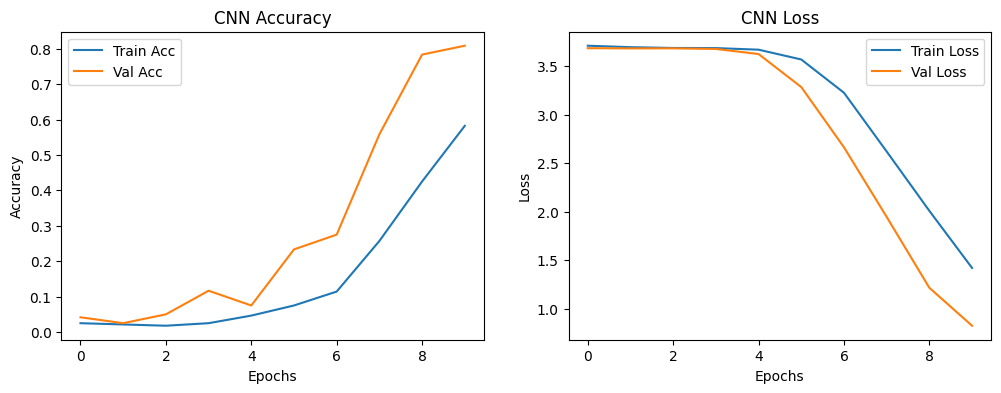

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


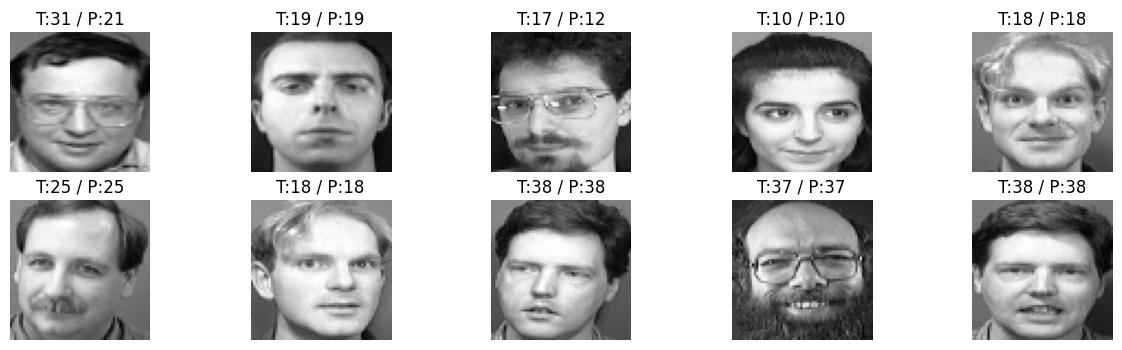

In [34]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1) + 1  # shift back to 1-based labels

plt.figure(figsize=(15, 4))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i].reshape(64, 64), cmap="gray")
    plt.title(f"T:{y_test[i]} / P:{y_pred[i]}")
    plt.axis("off")
plt.show()
